In [1]:
import os
from tqdm.notebook import tqdm, tnrange

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torch.utils.data import random_split
from torch.optim import AdamW

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Deep Learning - Pytorch Edition

Avant d'utiliser Tensorflow, nous avons essayé Pytorch. Cependant, nous avons du changer de framework pour des raisons de compatibilité avec la carte Raspberry.

Toutes les étapes pour l'apprentissage sont fonctionnelles, du chargement du dataset à l'observation des prédiction. Il y a aussi une transformation des poids au format de Pytorch au format onnx.

Cf section XXX du rapport

### Liste des cellules

 1. Création de la class Dataset
 1. Création des étapes de preprocessing
 1. Chargement des données
 1. Historgramme d'une image après le preprocessing
 1. Création du modèle de Deep Learning
 1. Création de la boucle d'entrainement
 1. Entrainement
 1. Comparaison des prédictions par rapport à la vérité terrain 
 1. Transformation des poids au format onnx

# Création de la class Dataset

In [2]:
def get_labels(name):
    labels = name[0].split("_")
    direction = float(labels[2])
#     direction -= 228
#     direction /= 228
        
    speed =  float(labels[3][:-4])
#     speed -= 114
#     speed /= 114
    
    return [direction, speed]

class RoadDataset(Dataset):
    def __init__(self, root_dir, num_img=None, transform=None):
        self.root_dir = root_dir
        
        image_name_list = np.array([
            name for name in os.listdir(root_dir)
                if os.path.isfile(os.path.join(root_dir, name)) and ".png" in name
        ])
        
        self._get_list_image(image_name_list, num_img)
            
        self.transform = transform
        
    def _get_list_image(self, name_list, num):
        np.random.shuffle(name_list)
        
        if num is None or num > len(name_list):
            num = len(name_list)
            
        self.image_names = name_list[:num]
        names = np.expand_dims(self.image_names, axis=0)    
        self.labels = np.apply_along_axis(get_labels, 0, names)
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = image.reshape(114, 228, -1)
        
        labels = self.labels[:, idx]

        if self.transform:
            sample = self.transform(image)
            
        return sample, labels

# Création des étapes de preprocessing

In [3]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sample.transpose((2, 0, 1))
        return torch.from_numpy(image)


class Normalize():
    
    def __call__(self, sample):
        norm_img = np.zeros(sample.shape)
        norm_img = cv2.normalize(sample, norm_img, 0, 255, cv2.NORM_MINMAX)
        norm_img = norm_img.reshape(69, 223, -1)
        return norm_img
    
class Crop:
    def __call__(self, sample):
        width = sample.shape[1]
        return sample[45:, :width-5]

# Chargement des données

In [4]:
torch.manual_seed(0)

tsfrm = transforms.Compose([Crop(), Normalize(), ToTensor()])
dataset = RoadDataset("../../data/datasetv3/", num_img=18000, transform=tsfrm)
print(len(dataset))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=True)

18000


# Historgramme d'une image après le preprocessing

torch.Size([69, 223])


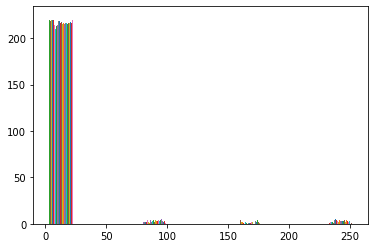

In [5]:
image = next(iter(train_dataset_loader))[0][0].reshape((69, 223))

print(image.shape)

plt.hist(image)
plt.show()

# Création du modèle de Deep Learning

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        nn.Conv2d
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.linear_layers = nn.Sequential(
            nn.Linear(468, 50),
            nn.ReLU(),
            nn.Linear(50, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )

    def forward(self, x):        
        x = self.cnn_layers(x)
        x = self.flatten(x)
        x = self.linear_layers(x)
        return x
        

# Création de la boucle d'entrainement

In [7]:
def train_and_build(n_epoches):
    loss_sum = 0
    iter_loss_update = 50
    loss_log = tqdm(total=50, desc='Loss', position=3)
    j = 0
    
    for epoch in tnrange(n_epoches+1, desc='Epoch', position=1):
        nn_model.train()
        
        tq = tqdm(train_dataset_loader, desc='Batch', position=2, leave=False)
        for _, (images, labels) in enumerate(tq):
            optimizer.zero_grad()
            
            images = images.float()
            labels = labels.float()
            
            outputs = nn_model(images)
            
            loss = loss_fn(outputs, labels)
            
            loss_sum += loss.data.item()
            if j % iter_loss_update == iter_loss_update-1:
                j = 0
                loss_log.set_description_str('Loss: {:.3f}'.format(loss_sum/iter_loss_update))
                loss_sum = 0
                loss_log.reset()
                
            loss.backward()
            optimizer.step()
            
            j += 1
            loss_log.update()
            
        if epoch%10 == 9:
            torch.save(nn_model.state_dict(), f"../../data/weights/weights_torch_v3_{epoch}.weights")

# Entrainement

In [8]:
nn_model = Network()
optimizer = AdamW(nn_model.parameters(), lr=0.001)

loss_fn = nn.MSELoss()

train_and_build(21)

Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/22 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

Batch:   0%|          | 0/57 [00:00<?, ?it/s]

# Comparaison des prédictions par rapport à la vérité terrain 

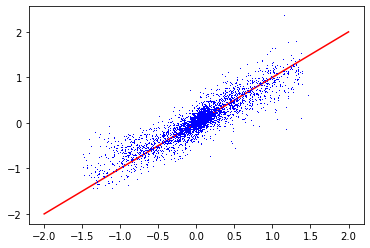

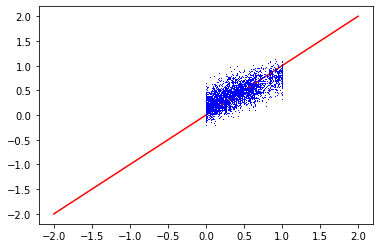

tensor(0.0439)


In [11]:
with torch.no_grad():
    nn_model = Network().cpu()
    nn_model.load_state_dict(torch.load("../../data/weights/weights_torch_v3_19.weights"))
    nn_model.eval()

    loss_fn = nn.MSELoss()

    test_acc_count = 0
    loss_sum = 0

    plt.figure(0)
    plt.plot([-2, 2], [-2, 2], color="red")
    plt.figure(1)
    plt.plot([-2, 2], [-2, 2], color="red")

    for k, (test_images, test_labels) in enumerate(test_dataset_loader):
        test_images = test_images.float()
        test_labels = test_labels.float()

        test_outputs = nn_model(test_images)
        loss_sum += loss_fn(test_outputs, test_labels).detach()

        test_outputs = test_outputs.cpu().detach().numpy()
        test_labels = test_labels.cpu().detach().numpy()
        
        plt.figure(0)
        plt.plot(test_labels[:, 0], test_outputs[:, 0], ',', color="blue")
        plt.figure(1)
        plt.plot(test_labels[:, 1], test_outputs[:, 1], ',', color="blue")

    plt.show()
    print((loss_sum/(k+1)).float())

# Transformation des poids au format onnx

In [12]:
nn_model = Network().cpu()
nn_model.load_state_dict(torch.load("../../data/weights/weights_torch_v3_19.weights"))

dummy_input = torch.randn(1, 1, 69, 223)

torch.onnx.export(nn_model, dummy_input, "../../data/weights/weights_torch_v3_19.onnx", verbose=True)

graph(%input.1 : Float(1:15387, 1:15387, 69:223, 223:1, requires_grad=0, device=cpu),
      %cnn_layers.0.weight : Float(3:9, 1:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %cnn_layers.0.bias : Float(3:1, requires_grad=1, device=cpu),
      %cnn_layers.3.weight : Float(3:27, 3:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %cnn_layers.3.bias : Float(3:1, requires_grad=1, device=cpu),
      %cnn_layers.6.weight : Float(3:27, 3:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %cnn_layers.6.bias : Float(3:1, requires_grad=1, device=cpu),
      %linear_layers.0.weight : Float(50:468, 468:1, requires_grad=1, device=cpu),
      %linear_layers.0.bias : Float(50:1, requires_grad=1, device=cpu),
      %linear_layers.2.weight : Float(8:50, 50:1, requires_grad=1, device=cpu),
      %linear_layers.2.bias : Float(8:1, requires_grad=1, device=cpu),
      %linear_layers.4.weight : Float(2:8, 8:1, requires_grad=1, device=cpu),
      %linear_layers.4.bias : Float(2:1, requires_grad=1, device=cpu)